In [102]:
# pip3 install gensim nltk numpy scipy matplotlib
# https://nlp.stanford.edu/projects/glove/
# https://cs.stanford.edu/people/jure/pubs/node2vec-kdd16.pdf

import gensim
import nltk
import json
import gzip
import numpy as np
import itertools
from vocab import Vocabulary
import matplotlib.pyplot as plt

In [93]:
# Read GLOVE vectors.
glove_vectors = np.zeros((400000, 50))
glove_vocabulary = Vocabulary()
with open('club-classifier/glove.6B.50d.txt') as f:
    for i, line in enumerate(f):
        args = line.split()
        word = args[0]
        glove_vectors[i] = [float(x) for x in args[1:]]
        i1 = glove_vocabulary.update(word)
        assert i1 == i

In [117]:
def v(w):
    return glove_vectors[glove_vocabulary.get(w)]

def d(v1, v2):
    return np.sum(v1 * v2) / np.linalg.norm(v1) / np.linalg.norm(v2)

print(d(v('king') - v('man') + v('woman'),  v('queen')))
print(d(v('king') - v('man') + v('woman'),  v('')))

0.8609581258578941
0.36743387143887596


In [120]:
json.load(open('club-classifier/clubs.json'))[2]

{'id': 3,
 'name': '1girl',
 'mission': 'To provide girls everywhere the opportunity to develop the skills and confidence they need to lead fulfilling lives and become successful leaders.',
 'timePlace': 'Wednesdays at 7:30pm; Neil Avenue; Columbus, OH 43210;',
 'membershipType': 'Open Membership',
 'membershipContact': 'ohiostate1girl@gmail.com',
 'membershipTime': 'Beginning of each Semester',
 'howToApply': 'Email to inquire about membership',
 'chargesDues': False,
 'created_at': '2018-03-04T05:51:30.457Z',
 'updated_at': '2018-03-04T05:51:30.457Z'}

10


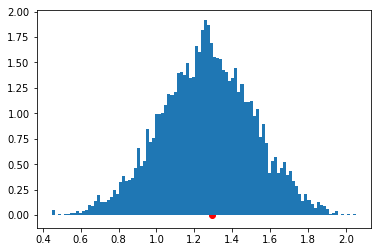

50


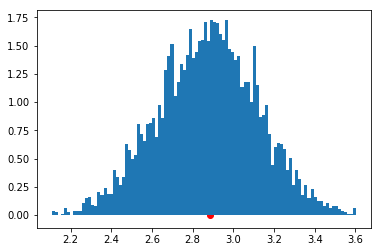

100


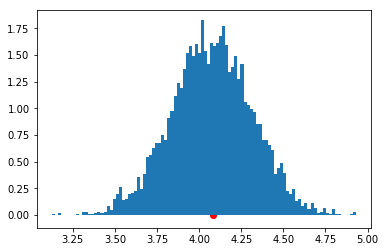

200


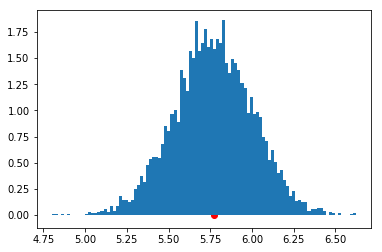

In [111]:
for D in [10, 50, 100, 200]:
    distances = []
    for _ in range(5000):
        x = np.random.uniform(size=D)
        y = np.random.uniform(size=D)
        d = np.sqrt(np.sum((x - y) ** 2))
        distances.append(d)
    print(D)
    plt.hist(distances, density=True, bins=100)
    plt.scatter([np.sqrt(D)/np.sqrt(6)], [0], color='red')
    plt.show();

In [17]:
KEYS = []
ENTITIES = []
INFOBOXES = []

with gzip.open('./whad-data/keys.json.gz') as fin:
    for i, line in enumerate(fin):
        line = json.loads(line)
        assert line['id'] == i
        KEYS.append(line)
        
with gzip.open('./whad-data/entities.json.gz') as fin:
    for i, line in enumerate(fin):
        line = json.loads(line)
        assert line['id'] == i
        ENTITIES.append(line)
        
with gzip.open('./whad-data/infoboxes.json.gz') as fin:
    for i, line in enumerate(fin):
        line = json.loads(line)
        assert line['id'] == i
        INFOBOXES.append(line)

In [18]:
EDGES = []
INCOMING = {}
OUTGOING = {}
        
with gzip.open('./whad-data/edges.json.gz') as fin:
    for i, line in enumerate(fin):
        line = json.loads(line)
        # EDGES.append(line)
        
        key = line['key']
        source = line['source']
        for target in line['targets']:
            OUTGOING.setdefault(source, set()).add((key, target))
            INCOMING.setdefault(target, set()).add((key, source))

In [19]:
RNG = np.random.RandomState(42)

In [77]:
def sample_random_paths(n=10):
    while True:
        e1 = RNG.randint(len(ENTITIES))
        last_key = None

        node_path = [e1]
        edge_path = []
        for _ in range(n):
            incoming = list(INCOMING.get(e1, []))
            outgoing = list(OUTGOING.get(e1, []))

            if len(outgoing) + len(incoming) == 0:
                break

            for _ in range(5):
                ei = RNG.randint(len(outgoing) + len(incoming))

                if ei >= len(outgoing):
                    ei -= len(outgoing)
                    key, e2 = incoming[ei]
                    inv = True
                else:
                    key, e2 = outgoing[ei]
                    inv = False
                    
                if key == last_key:
                    continue

                node_path.append(e2)
                edge_path.append((inv, key))

                e1 = e2
                last_key = key
                break
        yield node_path, edge_path
        
def sample_edge_paths(n=10, min_len=5):
    for _, path in sample_random_paths(n):
        if len(path) < min_len:
            continue
        
        for i, (inv, x) in enumerate(path):
            path[i] = ('¬' if inv else '') + KEYS[x]['name']
        yield path
        
def sample_node_paths(n=20, min_len=5):
    for path, _ in sample_random_paths(n):
        if len(path) < min_len:
            continue
            
        for i, x in enumerate(path):
            path[i] = ENTITIES[x]['name'].replace(' ', '_')
        yield path
        
def sample_infobox_paths(n=20, min_len=5):
    for path, _ in sample_random_paths(n):
        if len(path) < min_len:
            continue
            
        for i, x in enumerate(path):
            ibs = ENTITIES[x]['infoboxes']
            ib = ibs[0][0]
            path[i] = INFOBOXES[ib]['name'].replace(' ', '_')
        yield path

In [123]:
list(itertools.islice(sample_infobox_paths(10), 5))

[['uk_place',
  'england_county_unitary',
  'uk_place',
  'settlement',
  'uk_place',
  'uk_constituency_main',
  'uk_place',
  'england_county_unitary',
  'uk_school',
  'england_county_unitary',
  'uk_place'],
 ['person',
  'film',
  'programming_language',
  'christian_leader',
  'christian_leader',
  'christian_leader',
  'christian_leader',
  'bishopric',
  'church',
  'musical_artist'],
 ['magic:_the_gathering_player',
  'magic:_the_gathering_pro_tour_season',
  'magic:_the_gathering_pro_tour_season',
  'magic:_the_gathering_pro_tour_season',
  'magic:_the_gathering_player',
  'magic:_the_gathering_pro_tour_season',
  'magic:_the_gathering_player'],
 ['german_location',
  'german_location',
  'german_state',
  'district_de',
  'german_location',
  'german_state',
  'road'],
 ['writer',
  'album',
  'comics_creator',
  'comic_book_title',
  'comics_creator',
  'comics_character',
  'company',
  'comics_character',
  'comics_character',
  'comics_character',
  'comic_book_title']]

In [60]:
class CustomCorpus(object):
    def __init__(self, fname):
        self.fname = fname

    def __iter__(self):
        with gzip.open(self.fname, 'rt') as fin:
            for line in fin:
                yield line.strip().split('\t')

In [57]:
EDGE_CORPUS_PATH = 'whad-edge-corpus.txt.gz'
with gzip.open(EDGE_CORPUS_PATH, 'wt+') as fout:
    for path in itertools.islice(sample_edge_paths(10), 500000):
        print('\t'.join(path), file=fout)

In [61]:
from gensim.models import Word2Vec

In [63]:
edge_model = Word2Vec(CustomCorpus(EDGE_CORPUS_PATH), size=100, window=5, min_count=1, workers=4)

In [132]:
edge_model.wv.most_similar('children')

[('¬parents', 0.9128847122192383),
 ('parents', 0.9110609292984009),
 ('¬children', 0.9068242907524109),
 ('spouse', 0.8064637184143066),
 ('¬spouse', 0.7746407985687256),
 ('¬relations', 0.7589224576950073),
 ('¬spouses', 0.758327841758728),
 ('¬relatives', 0.7512246370315552),
 ('wife', 0.7479748725891113),
 ('¬wife', 0.7445101141929626)]

In [ ]:
INFOBOX_CORPUS_PATH = 'whad-infobox-corpus.txt.gz'
with gzip.open(INFOBOX_CORPUS_PATH, 'wt+') as fout:
    for path in itertools.islice(sample_infobox_paths(), 100000):
        print('\t'.join(path), file=fout)

In [ ]:
infobox_model = Word2Vec(CustomCorpus(INFOBOX_CORPUS_PATH), size=100, window=5, min_count=1, workers=4)

In [141]:
infobox_model.wv.most_similar('video_game')

[('vg_series', 0.8884174823760986),
 ('storage_medium', 0.8318207263946533),
 ('video_game_series', 0.8300854563713074),
 ('cvg_system', 0.8245033621788025),
 ('machinima', 0.8153306245803833),
 ('vg_online_service', 0.8023949861526489),
 ('e-sports_club', 0.773980975151062),
 ('computer', 0.770449697971344),
 ('vg', 0.7653200626373291),
 ('vg_character', 0.7477352023124695)]

In [88]:
NODE_CORPUS_PATH = 'whad-node-corpus.txt.gz'
with gzip.open(NODE_CORPUS_PATH, 'at') as fout:
    for path in itertools.islice(sample_node_paths(), 200000):
        print('\t'.join(path), file=fout)

In [142]:
node_model = Word2Vec(CustomCorpus(NODE_CORPUS_PATH), size=100, window=5, min_count=1, workers=4)

In [144]:
node_model.wv.most_similar('')

[('Jo_Dee_Messina', 0.964158833026886),
 ('On_the_Ride', 0.9599303007125854),
 ('Automatic_for_the_People', 0.9567062854766846),
 ('Got_Me_Under_Pressure', 0.9539003968238831),
 ('Hello_Pop!', 0.9534103274345398),
 ('Two_English_Girls', 0.9527778625488281),
 ('Rail_Simulator', 0.9520115852355957),
 ('Naruto:_Ultimate_Ninja_Storm', 0.9518694877624512),
 ('Monster_Truck_Madness', 0.9511873126029968),
 ('Hook,_Line_and_Stinker', 0.9510291218757629)]